In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score


2025-05-10 13:26:47.152148: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 13:26:47.154784: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 13:26:47.204295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 13:26:47.205489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 13:26:48.387341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
csv = "../../data/contaminated/contaminated_data_irm.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/contaminated_data_irm.npy").flatten().tolist()

In [3]:
masque_normaux = [i not in indices for i in range(len(contaminated))]
masque_anomalie = [i in indices for i in range(len(contaminated))]
#normaux = contaminated[masque_normaux].tolist()

anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

In [4]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
def vetorisation_sbert(data, indice_anomalie=None):
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : normal)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

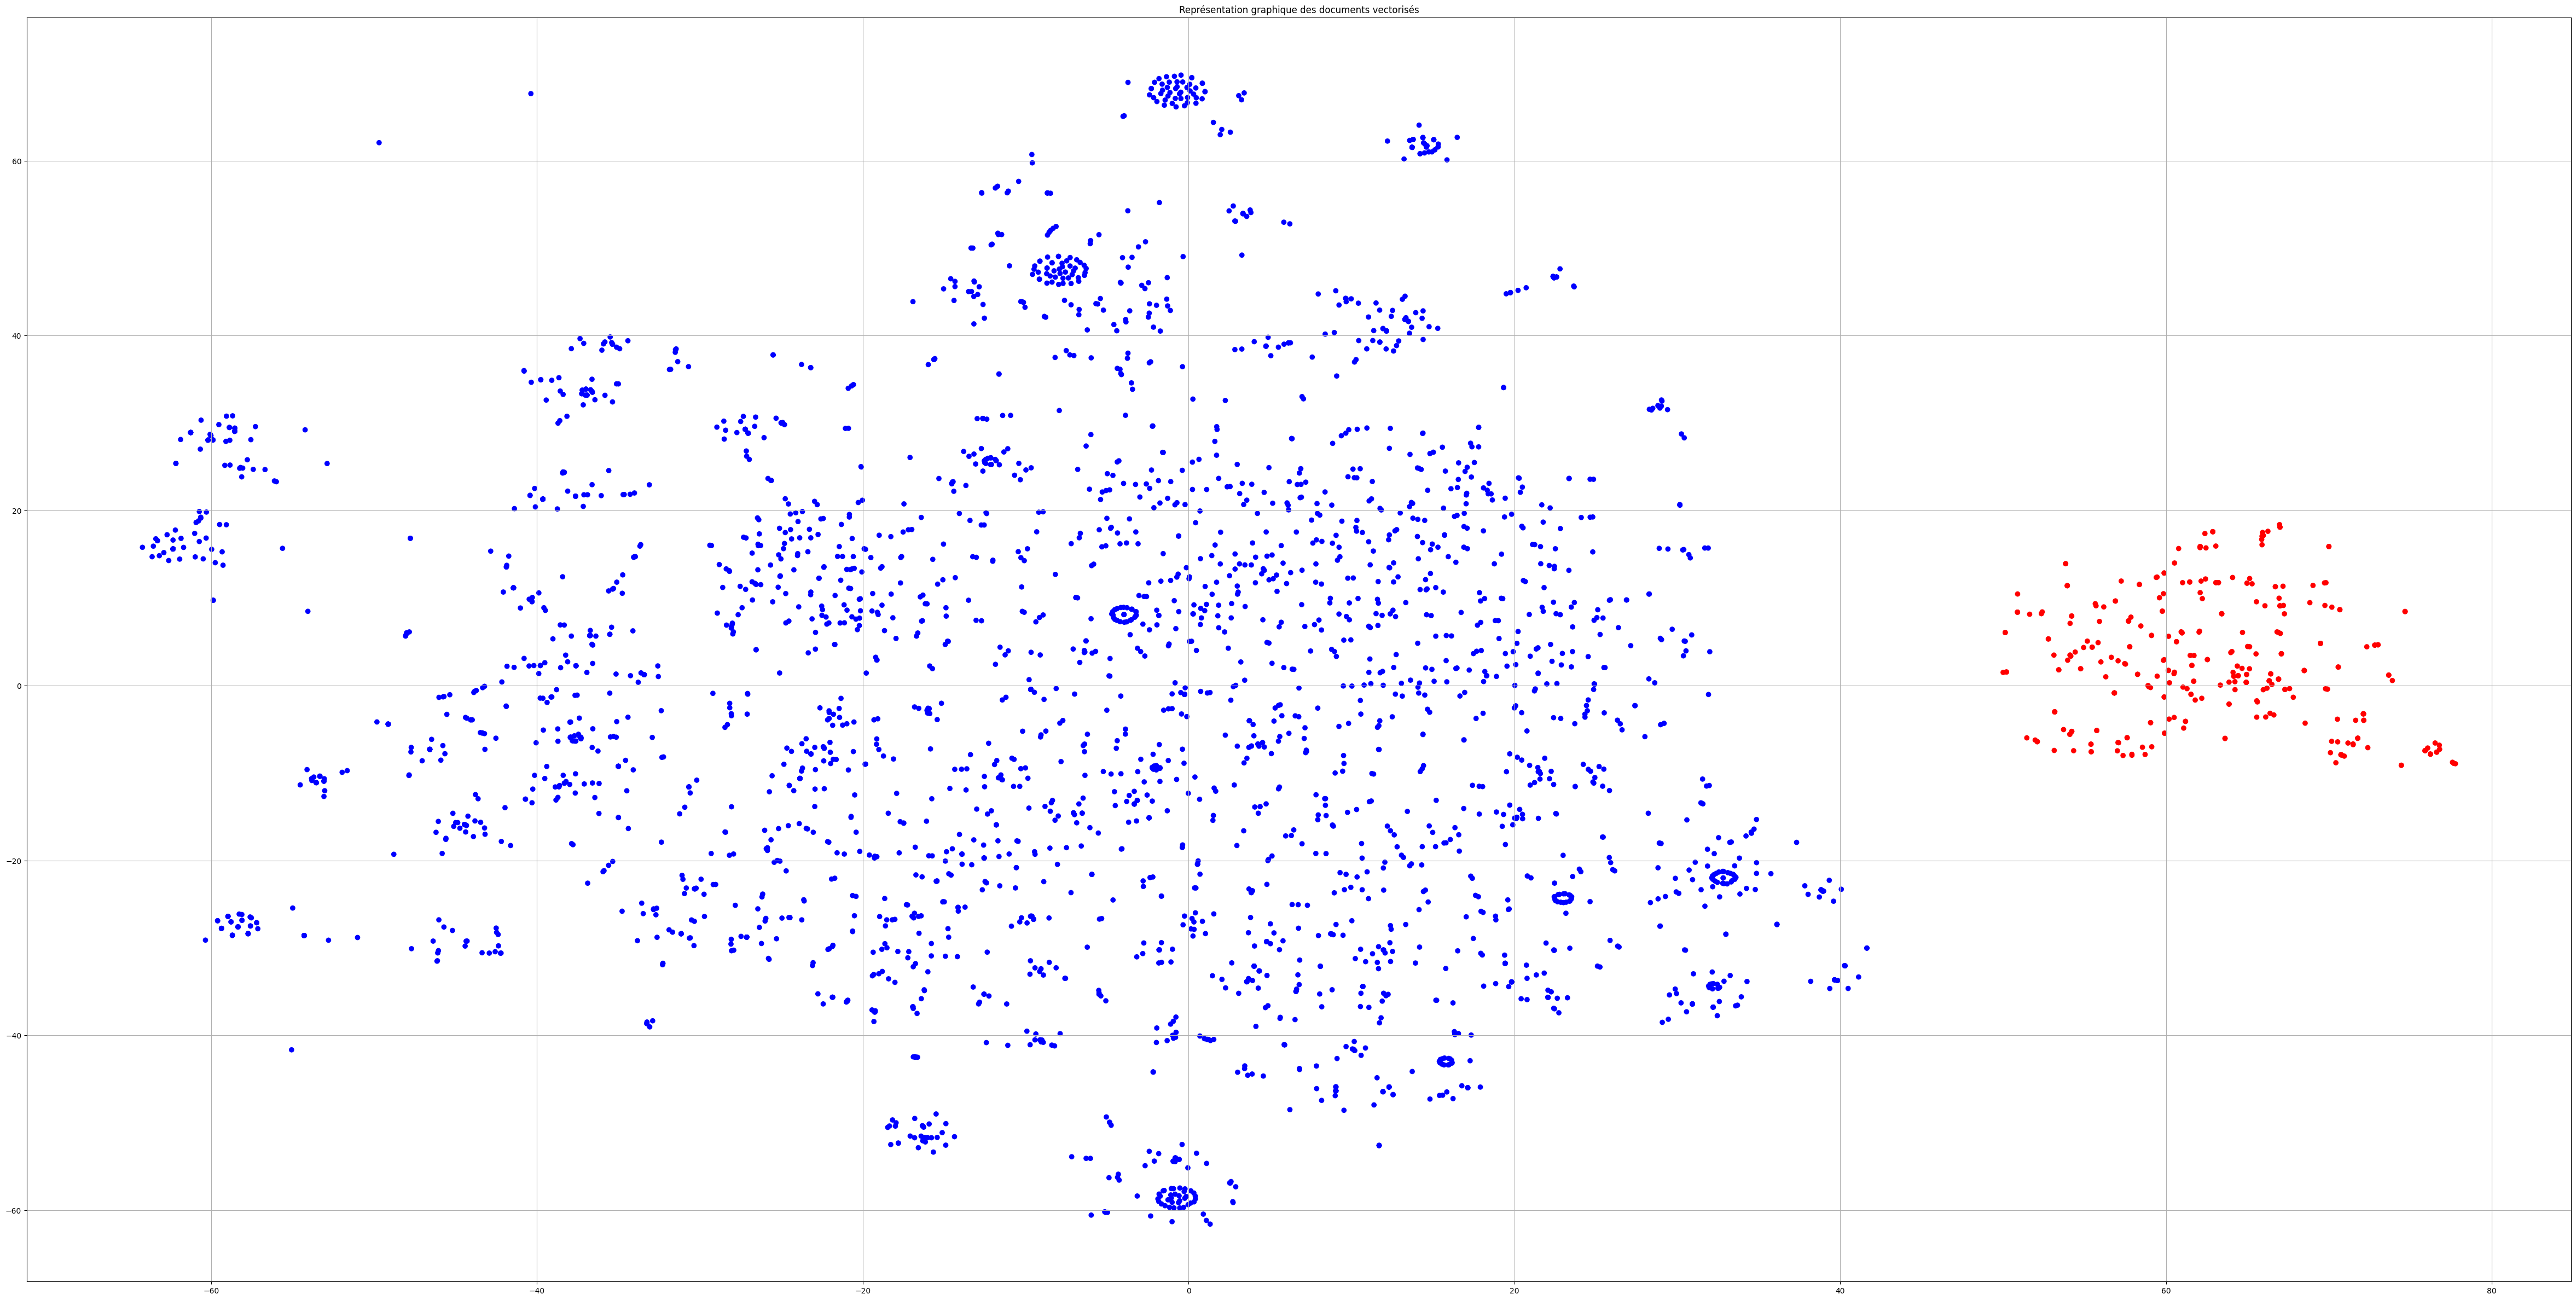

In [5]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [7]:
anomalie_tensor = torch.tensor(anomalie_sb[masque_normaux].tolist(), dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=anomalie_sb[masque_normaux].shape[1], latent_dim = 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0167
Epoch 2/50, Loss: 0.0083
Epoch 3/50, Loss: 0.0052
Epoch 4/50, Loss: 0.0029
Epoch 5/50, Loss: 0.0100
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0021
Epoch 8/50, Loss: 0.0018
Epoch 9/50, Loss: 0.0014
Epoch 10/50, Loss: 0.0013
Epoch 11/50, Loss: 0.0011
Epoch 12/50, Loss: 0.0022
Epoch 13/50, Loss: 0.0009
Epoch 14/50, Loss: 0.0012
Epoch 15/50, Loss: 0.0012
Epoch 16/50, Loss: 0.0011
Epoch 17/50, Loss: 0.0015
Epoch 18/50, Loss: 0.0010
Epoch 19/50, Loss: 0.0009
Epoch 20/50, Loss: 0.0006
Epoch 21/50, Loss: 0.0006
Epoch 22/50, Loss: 0.0008
Epoch 23/50, Loss: 0.0007
Epoch 24/50, Loss: 0.0010
Epoch 25/50, Loss: 0.0009
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0005
Epoch 28/50, Loss: 0.0006
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0006
Epoch 31/50, Loss: 0.0006
Epoch 32/50, Loss: 0.0010
Epoch 33/50, Loss: 0.0007
Epoch 34/50, Loss: 0.0010
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0004
Epoch 37/50, Loss: 0.0005
Epoch 38/50, Loss: 0.0005
Epoch 39/50, Loss: 0.


🔥 Meilleur seuil trouvé : 0.000705
📈 F1-score optimal : 0.9703

📊 Rapport de classification :

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3078
    Anomalie       0.98      0.96      0.97       341

    accuracy                           0.99      3419
   macro avg       0.99      0.98      0.98      3419
weighted avg       0.99      0.99      0.99      3419

AUC ROC : 0.9785
Average precision : 0.9458


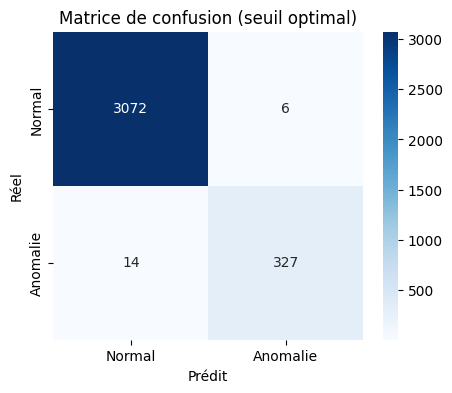

In [8]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(anomalie_sb.tolist() , dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn

# labels = [indices des anomalies connues]
labels = masque_anomalie

# le meilleur seuil basé sur le F1-score 
thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n🔥 Meilleur seuil trouvé : {best_threshold:.6f}")
print(f"📈 F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n📊 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc_ae = roc_auc_score(y_true, y_pred)
avg_precision_ae = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc_ae:.4f}")
print(f"Average precision : {avg_precision_ae:.4f}")

# matrice de confusion 

cm_ae = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


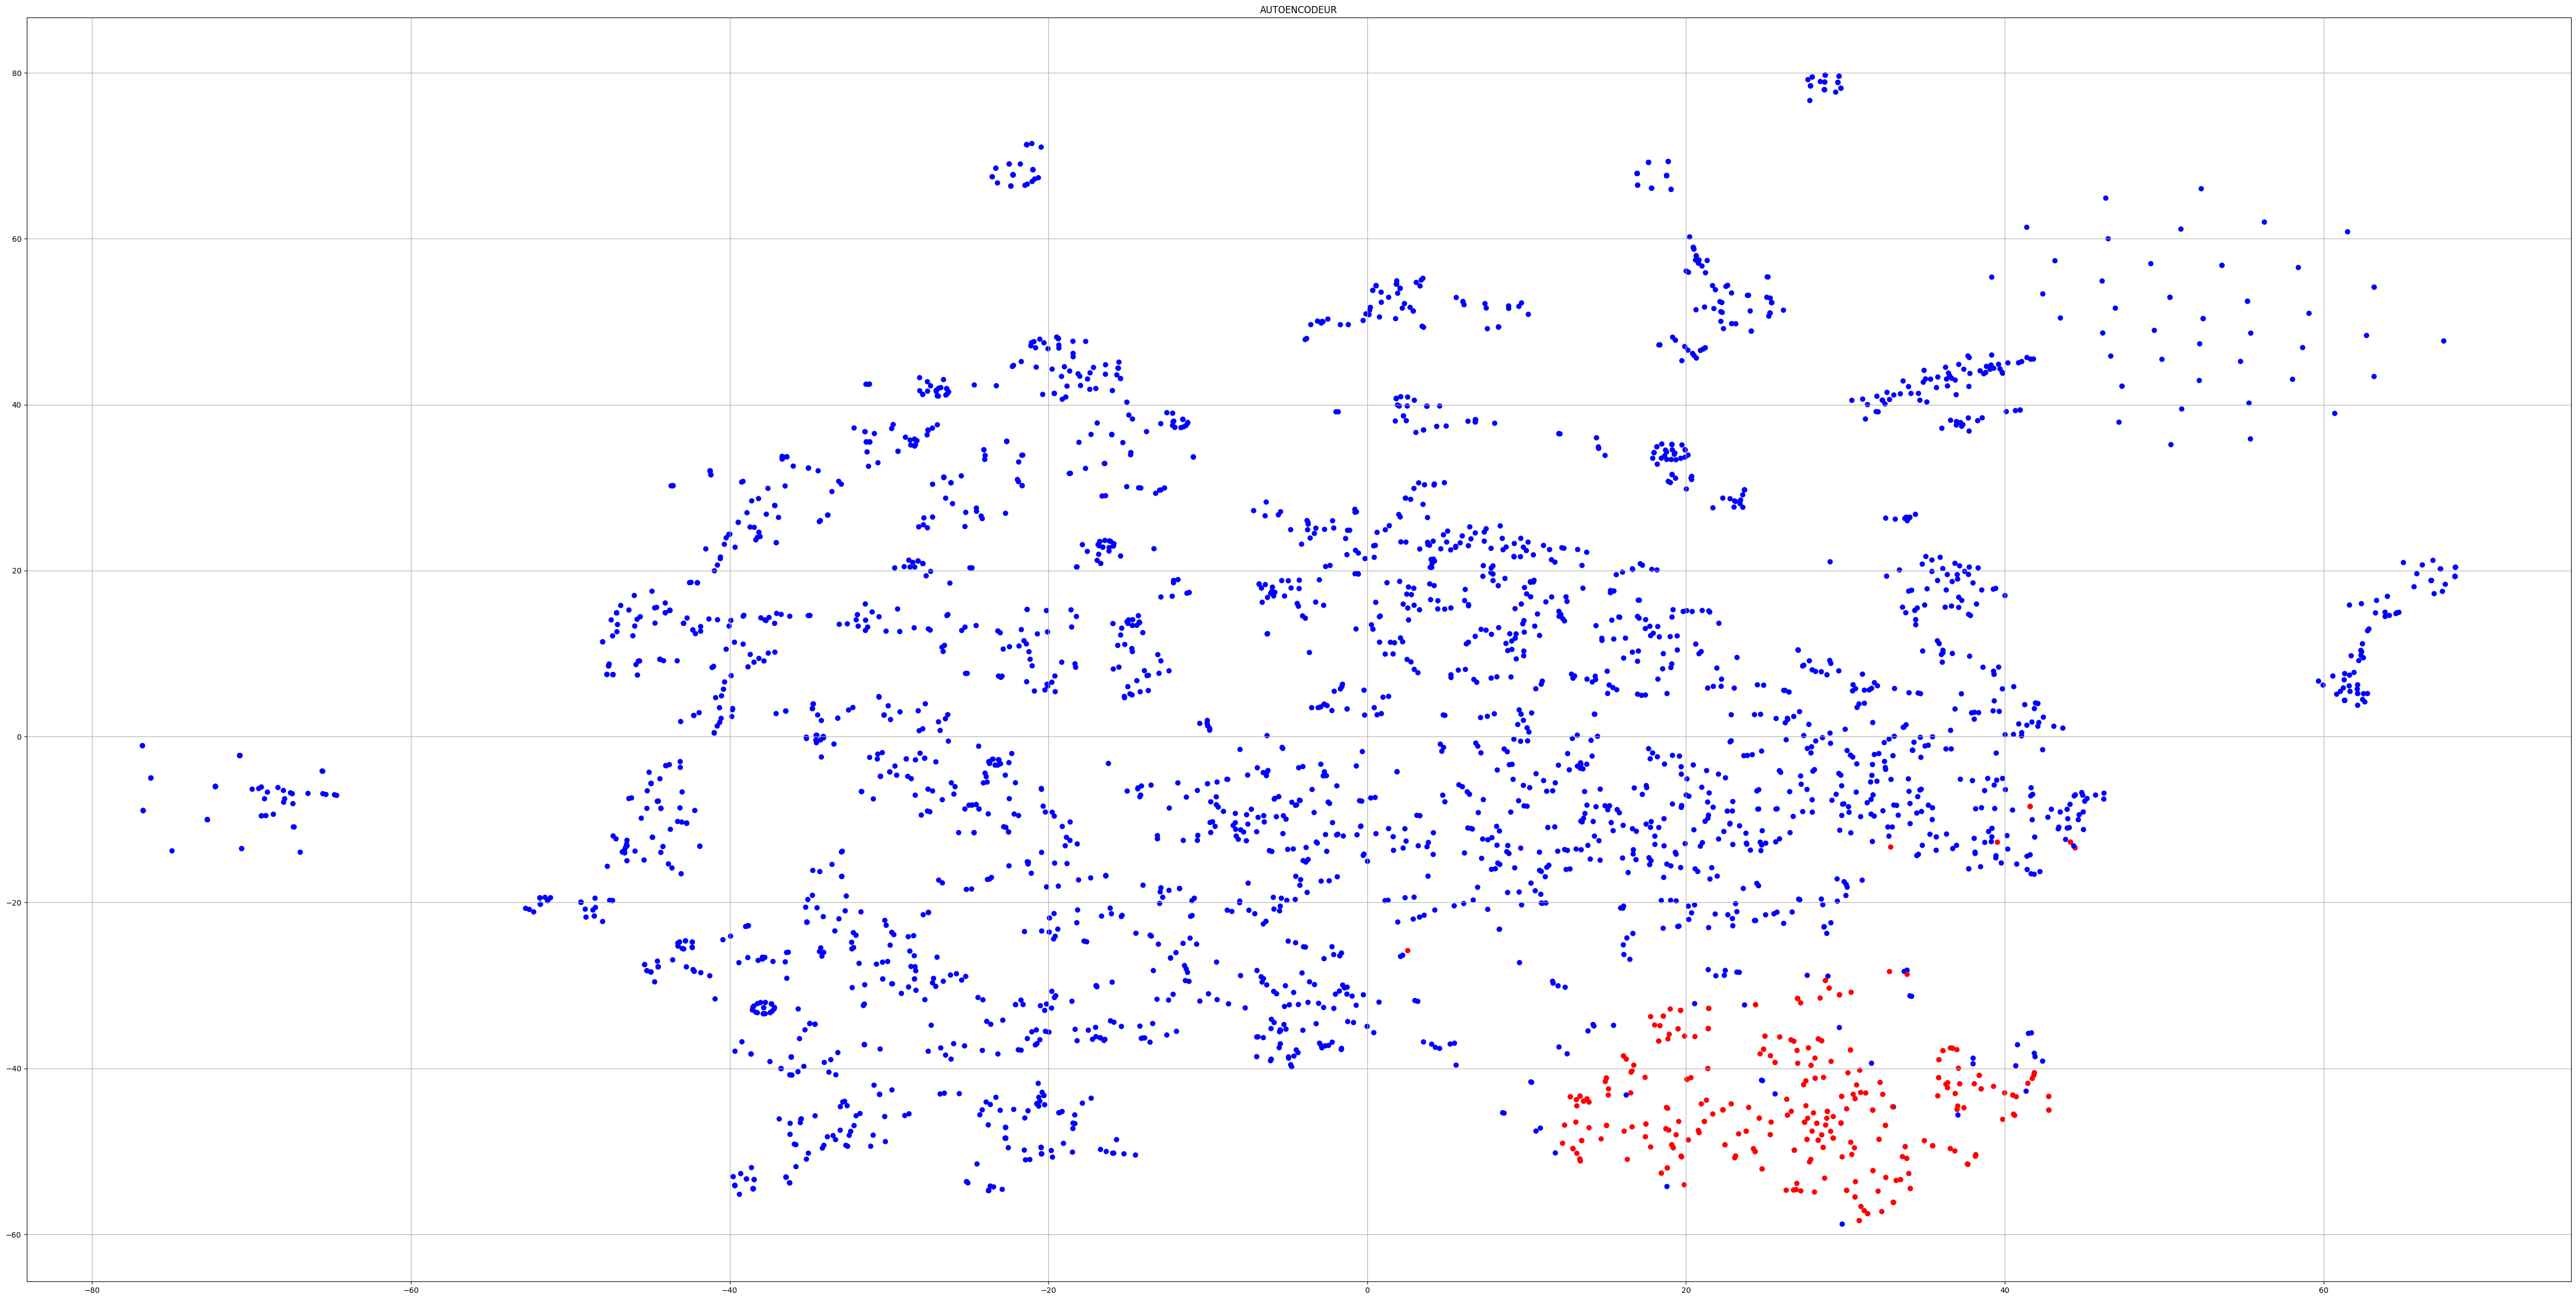

In [9]:
tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
reconstructed_2d = tsne.fit_transform(reconstructions)  # appliquer t-SNE

# couleurs des points ( rouge : anomalie, bleu : noraml)
couleurs = ['b'] * len(anomalie_sb)
for i in indices:
    if 0 <= i < len(anomalie_sb): 
        couleurs[i] = 'r'

# affichage graphique des données dans l'espace 2D
plt.figure(figsize=(60, 30)) 
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], c=couleurs, marker='o') 

plt.title("AUTOENCODEUR")
plt.grid(True)
#plt.savefig("output.jpg")
plt.show()

In [10]:
isolation_forest = IsolationForest()
isolation_forest.fit(anomalie_sb[masque_normaux].tolist())

IsolationForest()

In [11]:
i_forest = isolation_forest.decision_function(anomalie_sb)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3078
    Anomalie       0.99      0.98      0.99       341

    accuracy                           1.00      3419
   macro avg       0.99      0.99      0.99      3419
weighted avg       1.00      1.00      1.00      3419

AUC ROC : 0.9906
Average precision : 0.9726


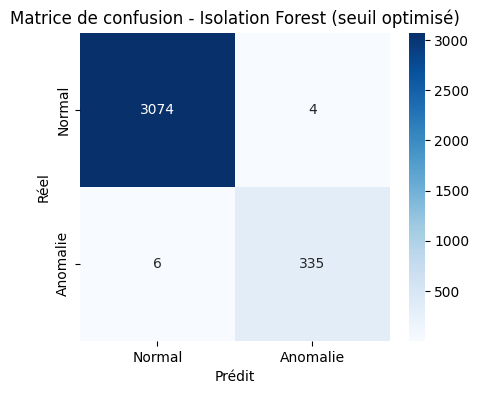

In [12]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc_if = roc_auc_score(y_true, y_pred)
avg_precision_if = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc_if:.4f}")
print(f"Average precision : {avg_precision_if:.4f}")
# Matrice de confusion
cm_if = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [13]:
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  
oc_svm.fit(anomalie_sb[masque_normaux].tolist())

OneClassSVM(nu=0.05)

In [14]:
svm_pred = oc_svm.decision_function(anomalie_sb)
svm_scores = -svm_pred #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      3078
    Anomalie       0.99      1.00      0.99       341

    accuracy                           1.00      3419
   macro avg       1.00      1.00      1.00      3419
weighted avg       1.00      1.00      1.00      3419

AUC ROC : 0.9980
Average precision : 0.9886


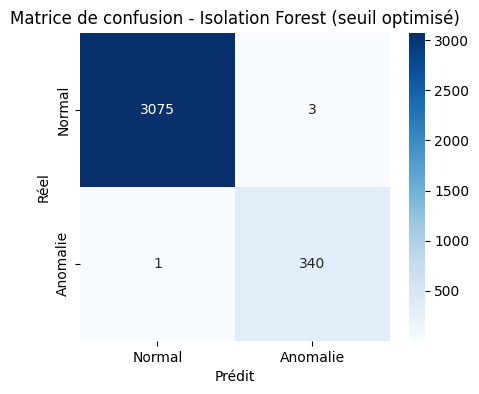

In [15]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc_svm = roc_auc_score(y_true, y_pred)
avg_precision_svm = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc_svm:.4f}")
print(f"Average precision : {avg_precision_svm:.4f}")
# Matrice de confusion
cm_svm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [19]:
results = {
    "Autoencoder": {
        "avg_prec": avg_precision_ae,
        "roc_auc": roc_auc_ae,
        "cm": cm_ae
    },
    "IsolationForest": {
        "avg_prec": avg_precision_if,
        "roc_auc": roc_auc_if,
        "cm": cm_if
    },
    "SVM": {
        "avg_prec": avg_precision_svm,
        "roc_auc": roc_auc_svm,
        "cm": cm_svm
    }
}

for method, metrics in results.items():
    cm = metrics["cm"]
    tn, fp, fn, tp = cm.ravel()
    total_pos = tp + fn
    total_neg = tn + fp

    results[method]["TPR %"] = round(tp / total_pos * 100, 2) if total_pos else 0  # Sensibilité (Recall)
    results[method]["FPR %"] = round(fp / total_neg * 100, 2) if total_neg else 0  # Faux positifs
    results[method]["TNR %"] = round(tn / total_neg * 100, 2) if total_neg else 0  # Spécificité
    results[method]["FNR %"] = round(fn / total_pos * 100, 2) if total_pos else 0  # Faux négatifs

In [20]:
benchmark_data = {
    method: {k: v for k, v in metrics.items() if k != "cm"}
    for method, metrics in results.items()
}

# Création du DataFrame
benchmark_df = pd.DataFrame(benchmark_data).T  # Méthodes en lignes
benchmark_df = benchmark_df.round(4)

# Affichage final
print("\n📊 Benchmark complet :\n")
print(benchmark_df)


📊 Benchmark complet :

                 avg_prec  roc_auc  TPR %  FPR %  TNR %  FNR %
Autoencoder        0.9458   0.9785  95.89   0.19  99.81   4.11
IsolationForest    0.9726   0.9906  98.24   0.13  99.87   1.76
SVM                0.9886   0.9980  99.71   0.10  99.90   0.29


In [21]:
benchmark_df.to_csv("../../benchmarks/benchmark_result_4.csv")